In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(patchwork)))
suppressPackageStartupMessages(suppressWarnings(library(cowplot)))
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML)))
suppressPackageStartupMessages(suppressWarnings(library(pheatmap)))
suppressPackageStartupMessages(suppressWarnings(library(lattice)))
suppressPackageStartupMessages(suppressWarnings(library("RColorBrewer")))
suppressPackageStartupMessages(suppressWarnings(library(gplots)))
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap)))
suppressPackageStartupMessages(suppressWarnings(library(ggplotify)))
# import the R them
figure_themes <- source(file.path("../figure_themes.r"))

## Generate each individual plot priot to combining them in a single figure (pathwork)

In [2]:
# Load in the treatment list
toml_path <- file.path("..","..","1.Exploratory_Data_Analysis/utils/params.toml")
p <- parseTOML(toml_path)
list_of_treatments <- c(p$list_of_treatments$treatments)
list_of_treatments

[1] "DMSO_0.100_DMSO_0.025"               "Thapsigargin_1.000_DMSO_0.025"      
 [3] "Thapsigargin_10.000_DMSO_0.025"      "H2O2_100.000_DMSO_0.025"            
 [5] "Flagellin_0.100_DMSO_0.025"          "Flagellin_1.000_DMSO_0.025"         
 [7] "LPS_0.010_DMSO_0.025"                "LPS_Nigericin_1.000_1.0_DMSO_0.025" 
 [9] "LPS_1.000_DMSO_0.025"                "LPS_Nigericin_1.000_3.0_DMSO_0.025" 
[11] "LPS_Nigericin_1.000_10.0_DMSO_0.025" "LPS_100.000_DMSO_0.025"

In [3]:
# Figure 2A

# Load data
data_path_cytokine_values <- file.path("..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well.csv")
cytokine_values <- read.csv(data_path_cytokine_values, header = TRUE, sep = ",")
# filter out the treatments that are not in the list
cytokine_values <- cytokine_values[cytokine_values$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]

In [4]:
list_of_treatments <- c(
    'DMSO_0.100_DMSO_0.025',
    'Thapsigargin_1.000_DMSO_0.025',
    'Thapsigargin_10.000_DMSO_0.025',
    'H2O2_100.000_DMSO_0.025',
    
    'LPS_Nigericin_1.000_1.0_DMSO_0.025',
    'LPS_Nigericin_1.000_3.0_DMSO_0.025',
    'LPS_Nigericin_1.000_10.0_DMSO_0.025',
    
    'Flagellin_0.100_DMSO_0.025',
    'Flagellin_1.000_DMSO_0.025',
    'LPS_0.010_DMSO_0.025',
    'LPS_1.000_DMSO_0.025',
    'LPS_100.000_DMSO_0.025')


In [5]:
# order the treatments
# cytokine_values$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(cytokine_values$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, levels = list_of_treatments)

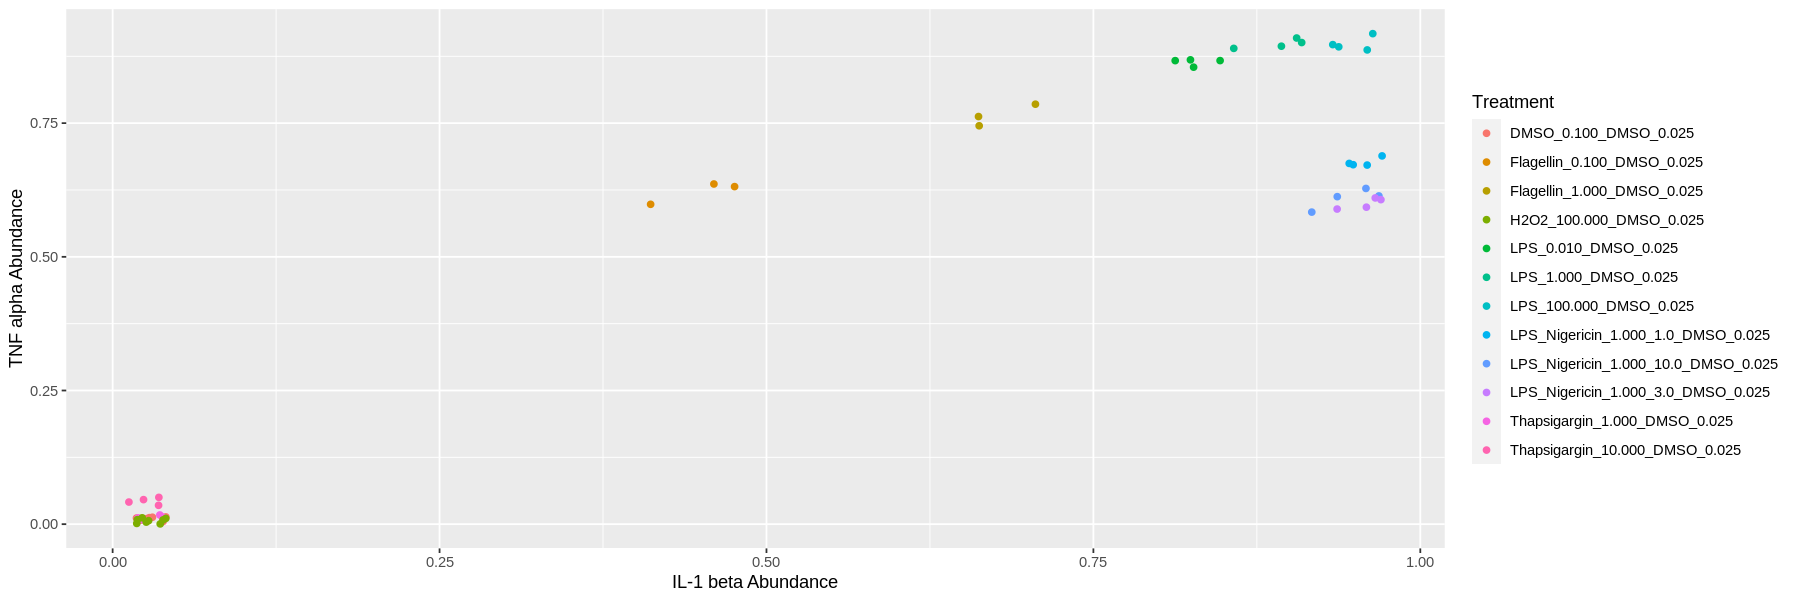

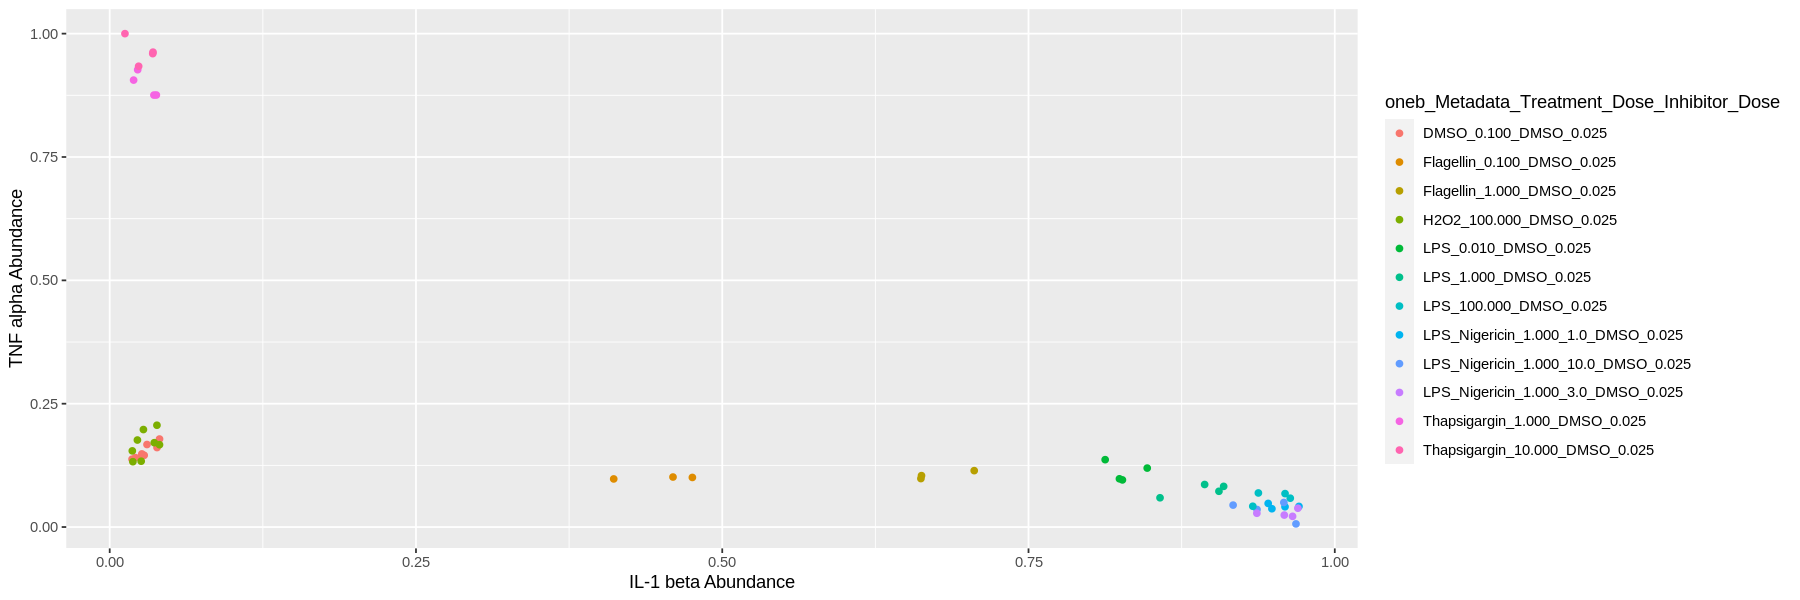

In [6]:
# set plot size
options(repr.plot.width=15, repr.plot.height=5)
# Plot
cytokine_scatter_plot <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = IL.1.beta..NSU.,
            y = TNF.alpha..NSU.,
            color = oneb_Metadata_Treatment_Dose_Inhibitor_Dose
        )
    )
    + geom_point()
    + xlab("IL-1 beta Abundance")
    + ylab("TNF alpha Abundance")
    + # rename legend title
    labs(color = "Treatment")
)

cytokine_scatter_plot

# set plot size
options(repr.plot.width=15, repr.plot.height=5)
# Plot
cytokine_scatter_plot1 <- (
    ggplot(
        data = cytokine_values,
        aes(
            x = IL.1.beta..NSU.,
            y = CCL24..NSU.,
            color = oneb_Metadata_Treatment_Dose_Inhibitor_Dose
        )
    )
    + geom_point()
    + xlab("IL-1 beta Abundance")
    + ylab("TNF alpha Abundance")
)

cytokine_scatter_plot1

### Bar plots of cytokine concentration

In [7]:
# import melted dataframes
# Figure 2A

# Load data
data_path_cytokine_values_melted <- file.path("..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well_melted.csv")
cytokine_values_melted <- read.csv(data_path_cytokine_values_melted, header = TRUE, sep = ",")
# filter out the treatments that are not in the list
cytokine_values_melted <- cytokine_values_melted[cytokine_values_melted$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]

In [8]:
head(cytokine_values_melted)

,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Cytokine,Cytokine_Value
,<chr>,<chr>,<dbl>
1,DMSO_0.100_DMSO_0.025,AITRL (GITR Ligand) [NSU],0.4616851
2,DMSO_0.100_DMSO_0.025,AITRL (GITR Ligand) [NSU],0.4511808
3,DMSO_0.100_DMSO_0.025,AITRL (GITR Ligand) [NSU],0.1963179
4,DMSO_0.100_DMSO_0.025,AITRL (GITR Ligand) [NSU],0.5966005
5,DMSO_0.100_DMSO_0.025,AITRL (GITR Ligand) [NSU],0.4908317
6,DMSO_0.100_DMSO_0.025,AITRL (GITR Ligand) [NSU],0.5412872


In [9]:
# select a few cytokines to visualize
cytokine_values_melted <- cytokine_values_melted[cytokine_values_melted$Cytokine %in% c(
    "IL-1 beta [NSU]",
    "TNF alpha [NSU]",
    "CCL24 [NSU]",
    "IL-18 [NSU]",
    "IL-6 [NSU]",
    "Osteopontin (OPN) [NSU]",
    "CCL13 [NSU]",
    "IL-2 [NSU]"
    ),]
head(cytokine_values_melted)

,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Cytokine,Cytokine_Value
,<chr>,<chr>,<dbl>
2619,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.12026529
2620,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.13602044
2621,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.10886278
2622,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.12124716
2623,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.09147803
2624,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.16066471


In [10]:
# set the order of the cytokines
cytokine_values_melted$Cytokine <- factor(cytokine_values_melted$Cytokine, levels = c(
    "IL-1 beta [NSU]",
    "TNF alpha [NSU]",
    
    "IL-18 [NSU]",
    "IL-6 [NSU]",
    
    
    "IL-2 [NSU]",
    "Osteopontin (OPN) [NSU]",
    "CCL13 [NSU]",
    "CCL24 [NSU]"
    ))

In [11]:
head(cytokine_values_melted)

,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Cytokine,Cytokine_Value
,<chr>,<fct>,<dbl>
2619,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.12026529
2620,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.13602044
2621,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.10886278
2622,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.12124716
2623,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.09147803
2624,DMSO_0.100_DMSO_0.025,CCL13 [NSU],0.16066471


In [12]:
# aggreate the data to get both the mean and the standard deviation
cytokine_values_melted_agg <- cytokine_values_melted %>% 
    group_by(Cytokine, oneb_Metadata_Treatment_Dose_Inhibitor_Dose) %>% 
    summarise(
        mean = mean(Cytokine_Value),
        sd = sd(Cytokine_Value)
    )
head(cytokine_values_melted_agg)

`summarise()` has grouped output by 'Cytokine'. You can override using the
`.groups` argument.


Cytokine,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,mean,sd
<fct>,<chr>,<dbl>,<dbl>
IL-1 beta [NSU],DMSO_0.100_DMSO_0.025,0.02866156,0.007810220
IL-1 beta [NSU],Flagellin_0.100_DMSO_0.025,0.44894301,0.033451089
IL-1 beta [NSU],Flagellin_1.000_DMSO_0.025,0.67682850,0.024983167
IL-1 beta [NSU],H2O2_100.000_DMSO_0.025,0.02859600,0.008840288
IL-1 beta [NSU],LPS_0.010_DMSO_0.025,0.82758329,0.014268464
IL-1 beta [NSU],LPS_1.000_DMSO_0.025,0.89146453,0.023679402


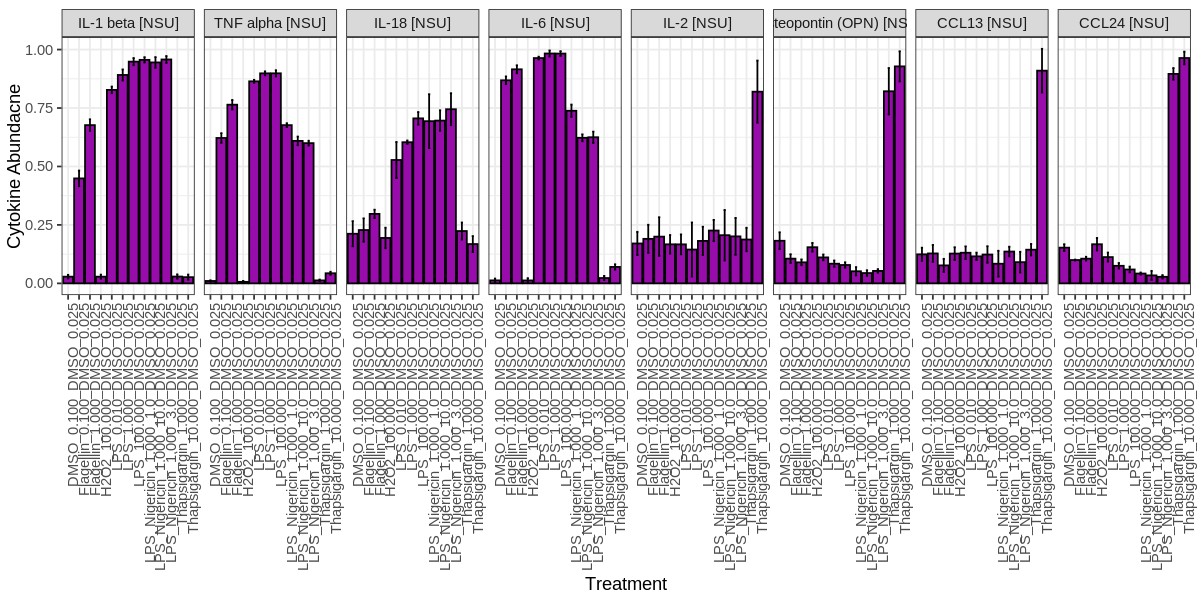

In [13]:
# set plot size 
options(repr.plot.width=10, repr.plot.height=5)
# make the bar plots for the cytokine values
cytokine_bar_plot <- (
    ggplot(data=cytokine_values_melted_agg,
           aes(x=oneb_Metadata_Treatment_Dose_Inhibitor_Dose,
                y=mean))
    + geom_bar(stat="identity", position="dodge", color='black', fill='#980CAB')
    + theme_bw()
    + geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2, position=position_dodge(.9))
    + facet_wrap(.~Cytokine, nrow =1)
    + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    + ylab("Cytokine Abundacne")
    + xlab("Treatment")

)

cytokine_bar_plot


### Heatmap of cytokine concentration

In [14]:
# Load data
data_path_cytokine_values_melted <- file.path("..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well_melted.csv")
cytokine_values_melted <- read.csv(data_path_cytokine_values_melted, header = TRUE, sep = ",")
# filter out the treatments that are not in the list
cytokine_values_melted <- cytokine_values_melted[cytokine_values_melted$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]
# heatmap of the cytokine values
# get the aggregated values for the cytokine values across the treatments
cytokine_values_melted_agg <- cytokine_values_melted %>%
    group_by(oneb_Metadata_Treatment_Dose_Inhibitor_Dose, Cytokine) %>%
    summarise(Cytokine_Value = mean(Cytokine_Value))

`summarise()` has grouped output by
'oneb_Metadata_Treatment_Dose_Inhibitor_Dose'. You can override using the
`.groups` argument.


In [15]:
# drop two columns by name 
cytokine_values_agg <- subset(cytokine_values, select = -c(fourb_Metadata_Treatment_Dose_Inhibitor_Dose, Metadata_position_x))
# aggregate the cytokine values across the treatments and cytokine
cytokine_values_agg <- cytokine_values_agg %>%
    group_by(oneb_Metadata_Treatment_Dose_Inhibitor_Dose) %>%
    summarise_all(mean)
# cytokine_values_agg <- as.matrix(cytokine_values_agg)

In [16]:
head(cytokine_values_melted_agg)

oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Cytokine,Cytokine_Value
<chr>,<chr>,<dbl>
DMSO_0.100_DMSO_0.025,AITRL (GITR Ligand) [NSU],0.4940995
DMSO_0.100_DMSO_0.025,APRIL [NSU],0.4744615
DMSO_0.100_DMSO_0.025,Amphiregulin [NSU],0.2391468
DMSO_0.100_DMSO_0.025,Amyloid beta [NSU],0.4820596
DMSO_0.100_DMSO_0.025,BAFF [NSU],0.3851330
DMSO_0.100_DMSO_0.025,BCMA (TNFRSF17) [NSU],0.6010184


In [17]:
# create a matrix of the cytokine values for the clustering and heatmap
# unmelt the data 
cytokine_values_agg <- reshape2::dcast(cytokine_values_melted_agg, oneb_Metadata_Treatment_Dose_Inhibitor_Dose ~ Cytokine, value.var = "Cytokine_Value")# make oneb_Metadata_Treatment_Dose_Inhibitor_Dose the rownames
rownames(cytokine_values_agg) <- cytokine_values_agg$oneb_Metadata_Treatment_Dose_Inhibitor_Dose
# drop the column
cytokine_values_agg <- subset(cytokine_values_agg, select = -c(oneb_Metadata_Treatment_Dose_Inhibitor_Dose))
# convert to matrix
# cytokine_values_agg <- as.matrix(cytokine_values_agg)
# 

In [18]:
cytokine_values_agg

,AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],BMP4 [NSU],⋯,TWEAK [NSU],uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU]
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DMSO_0.100_DMSO_0.025,0.4940995,0.2391468,0.4820596,0.4744615,0.3851330,0.6010184,0.2504846,0.4196230,0.3238476,0.4983901,⋯,0.4583241,0.4528880,0.3506292,0.4413733,0.4563148,0.5649021,0.3833757,0.1963640,0.4166624,0.1974226
Flagellin_0.100_DMSO_0.025,0.4253460,0.7050151,0.4593924,0.4260422,0.2242794,0.7528581,0.3221376,0.4429644,0.2580077,0.3996532,⋯,0.5019655,0.4314603,0.2358052,0.5965447,0.3264541,0.6683090,0.3861282,0.8738403,0.5312407,0.2808298
Flagellin_1.000_DMSO_0.025,0.4904394,0.6051925,0.2976367,0.6013109,0.3518636,0.5458658,0.2913660,0.4992969,0.2487722,0.3961059,⋯,0.4191222,0.3752929,0.4988428,0.3697211,0.1834858,0.6641498,0.3145838,0.7820253,0.5147191,0.2463458
H2O2_100.000_DMSO_0.025,0.5115611,0.2272169,0.4636570,0.4417151,0.4309337,0.6162960,0.2849073,0.4184149,0.3352675,0.4274657,⋯,0.4954249,0.3539327,0.2955180,0.4299799,0.5170386,0.5577470,0.3452894,0.1645261,0.4833064,0.2889363
LPS_0.010_DMSO_0.025,0.5305926,0.7979989,0.3748571,0.2887992,0.1746104,0.6509819,0.2484205,0.3274965,0.2629473,0.4443178,⋯,0.4027949,0.3597904,0.3929806,0.5834812,0.2496546,0.3790703,0.2128030,0.7566101,0.4915627,0.2781743
LPS_1.000_DMSO_0.025,0.4341179,0.8459839,0.3802853,0.2419478,0.1637697,0.6409205,0.3033194,0.3964669,0.2631938,0.3500960,⋯,0.4960238,0.3088554,0.4147529,0.4552616,0.2914029,0.4766003,0.3810032,0.6964306,0.5248204,0.3426674
LPS_100.000_DMSO_0.025,0.3755686,0.8327301,0.3575113,0.2775752,0.1502788,0.5861001,0.3055079,0.3979678,0.1986645,0.5061023,⋯,0.4806439,0.3956722,0.3724116,0.5383307,0.2497268,0.4778596,0.2827095,0.5935243,0.4404550,0.2288888
LPS_Nigericin_1.000_1.0_DMSO_0.025,0.4644112,0.5450045,0.5945623,0.4134010,0.4096409,0.2653990,0.4398407,0.4962380,0.5628849,0.5737959,⋯,0.4446270,0.5468399,0.4790752,0.5527220,0.7128927,0.6542048,0.6717494,0.1923713,0.5525188,0.4711697
LPS_Nigericin_1.000_10.0_DMSO_0.025,0.5368973,0.4405700,0.6501414,0.6093883,0.5850489,0.4289432,0.6980662,0.8582963,0.8169732,0.4754816,⋯,0.7329642,0.6754801,0.3696566,0.3687362,0.7443021,0.3583349,0.7905405,0.2231693,0.5594641,0.6843425


In [19]:
row_dend <- as.dendrogram(hclust(dist(cytokine_values_agg)))
col_dend <- as.dendrogram(hclust(dist(t(cytokine_values_agg))))

In [20]:
# remove '[NSU]' from the column names
colnames(cytokine_values_agg) <- gsub("\\[NSU\\]", "", colnames(cytokine_values_agg))


In [21]:
cytokine_values_agg <- as.matrix(cytokine_values_agg)

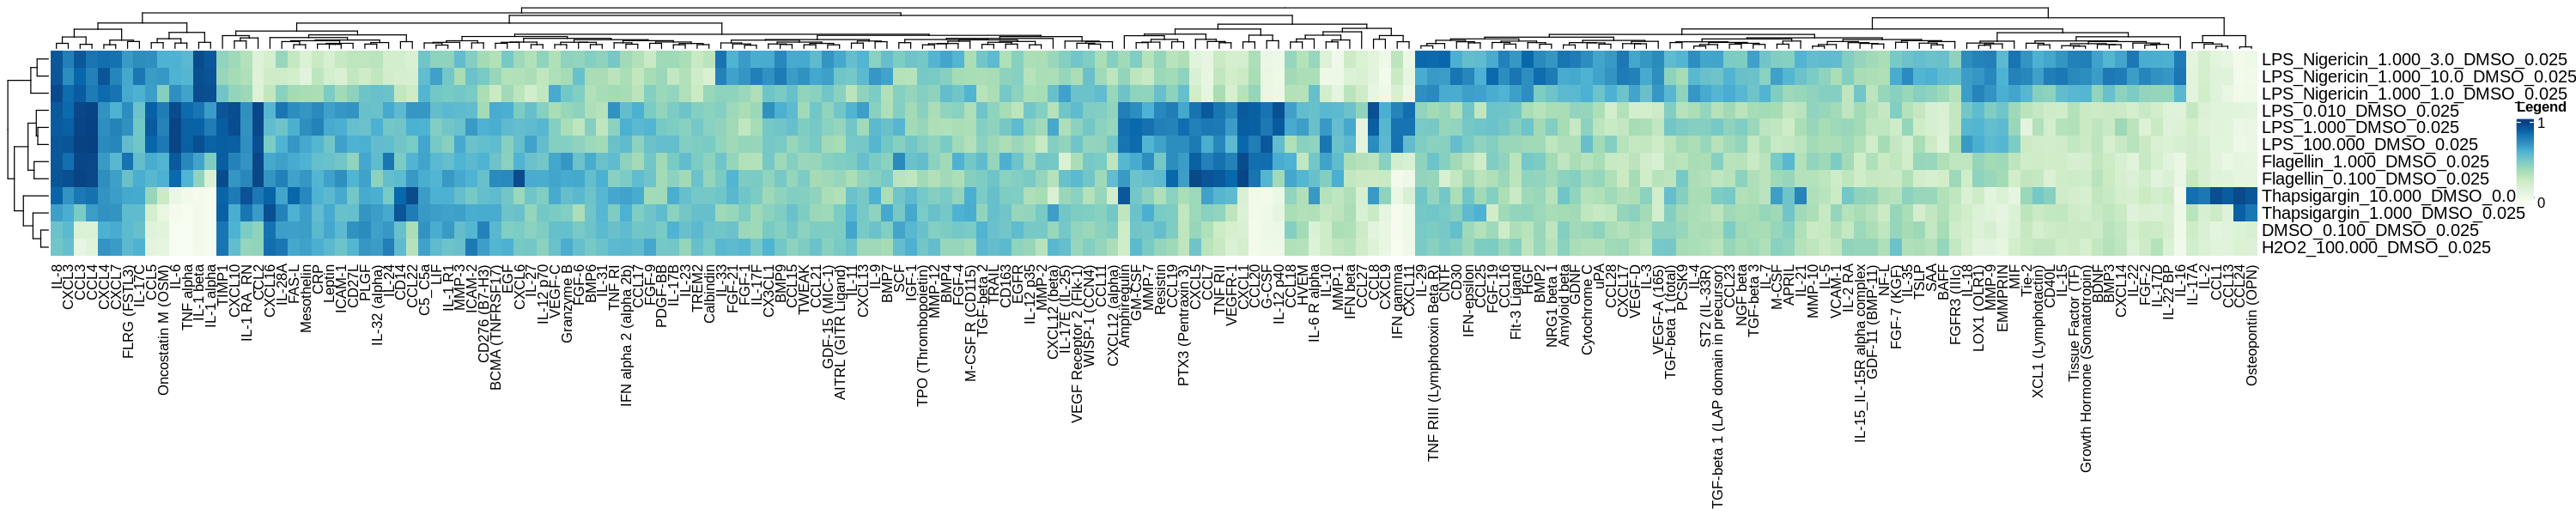

In [22]:
# set plot size 
options(repr.plot.width=25, repr.plot.height=5)
heatmap_plot_all <- (
  Heatmap(
  (cytokine_values_agg),
  col = brewer.pal(9, "GnBu"),
  cluster_rows = TRUE,    # Cluster rows
  cluster_columns = TRUE, # Cluster columns
  show_row_names = TRUE,  # Show row names
  show_column_names = TRUE, # Show column names
  column_names_gp = gpar(fontsize = 10), # Column name label formatting
  row_names_gp = gpar(fontsize = 12),    # Row name label formatting
  heatmap_legend_param = list(title = "Legend", at = c(0, 1)),
  # make the tiles rectangular
  rect_gp = gpar(col = NA),
  )
)
heatmap_plot_all

In [23]:
# import the tukey test results
tukey_results_path <- file.path("..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/tukey_test_results.csv")
# read in the data
tukey_results <- read.csv(tukey_results_path, header = TRUE, sep = ",")

# reload in the cytokine values
data_path_cytokine_values_melted <- file.path("..","..","2.Nomic_nELISA_Analysis/0.Exploratory_Analysis/PBMC/results/PBMC_all_cytokine_values_per_treatment_per_well_melted.csv")
cytokine_values_melted <- read.csv(data_path_cytokine_values_melted, header = TRUE, sep = ",")
# filter out the treatments that are not in the list
cytokine_values_melted <- cytokine_values_melted[cytokine_values_melted$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments,]

# aggregate the cytokine values across the treatments and cytokine
cytokine_values_melted_agg <- cytokine_values_melted %>%
    group_by(oneb_Metadata_Treatment_Dose_Inhibitor_Dose, Cytokine) %>%
    summarise(Cytokine_Value = mean(Cytokine_Value))

`summarise()` has grouped output by
'oneb_Metadata_Treatment_Dose_Inhibitor_Dose'. You can override using the
`.groups` argument.


In [24]:
cytokine_values_melted_agg_filtered <- cytokine_values_melted_agg[cytokine_values_melted_agg$Cytokine %in% unique(tukey_results$cytokine),]
head(cytokine_values_melted_agg_filtered)

oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Cytokine,Cytokine_Value
<chr>,<chr>,<dbl>
DMSO_0.100_DMSO_0.025,APRIL [NSU],0.4744615
DMSO_0.100_DMSO_0.025,Amphiregulin [NSU],0.2391468
DMSO_0.100_DMSO_0.025,Amyloid beta [NSU],0.4820596
DMSO_0.100_DMSO_0.025,BAFF [NSU],0.3851330
DMSO_0.100_DMSO_0.025,BCMA (TNFRSF17) [NSU],0.6010184
DMSO_0.100_DMSO_0.025,BDNF [NSU],0.2504846


In [25]:
# un melt the data cytokine_values_melted_agg_filtered
cytokine_values_melted_agg_filtered <- reshape2::dcast(cytokine_values_melted_agg_filtered, oneb_Metadata_Treatment_Dose_Inhibitor_Dose ~ Cytokine, value.var = "Cytokine_Value")

# make oneb_Metadata_Treatment_Dose_Inhibitor_Dose the index
row.names(cytokine_values_melted_agg_filtered) <- cytokine_values_melted_agg_filtered$oneb_Metadata_Treatment_Dose_Inhibitor_Dose
# drop the column
cytokine_values_melted_agg_filtered <- subset(cytokine_values_melted_agg_filtered, select = -c(oneb_Metadata_Treatment_Dose_Inhibitor_Dose))

In [26]:
cytokine_values_melted_agg_filtered <- as.matrix(cytokine_values_melted_agg_filtered)

In [27]:
# remove '[NSU]' from the column names
colnames(cytokine_values_melted_agg_filtered) <- gsub("\\[NSU\\]", "", colnames(cytokine_values_melted_agg_filtered))

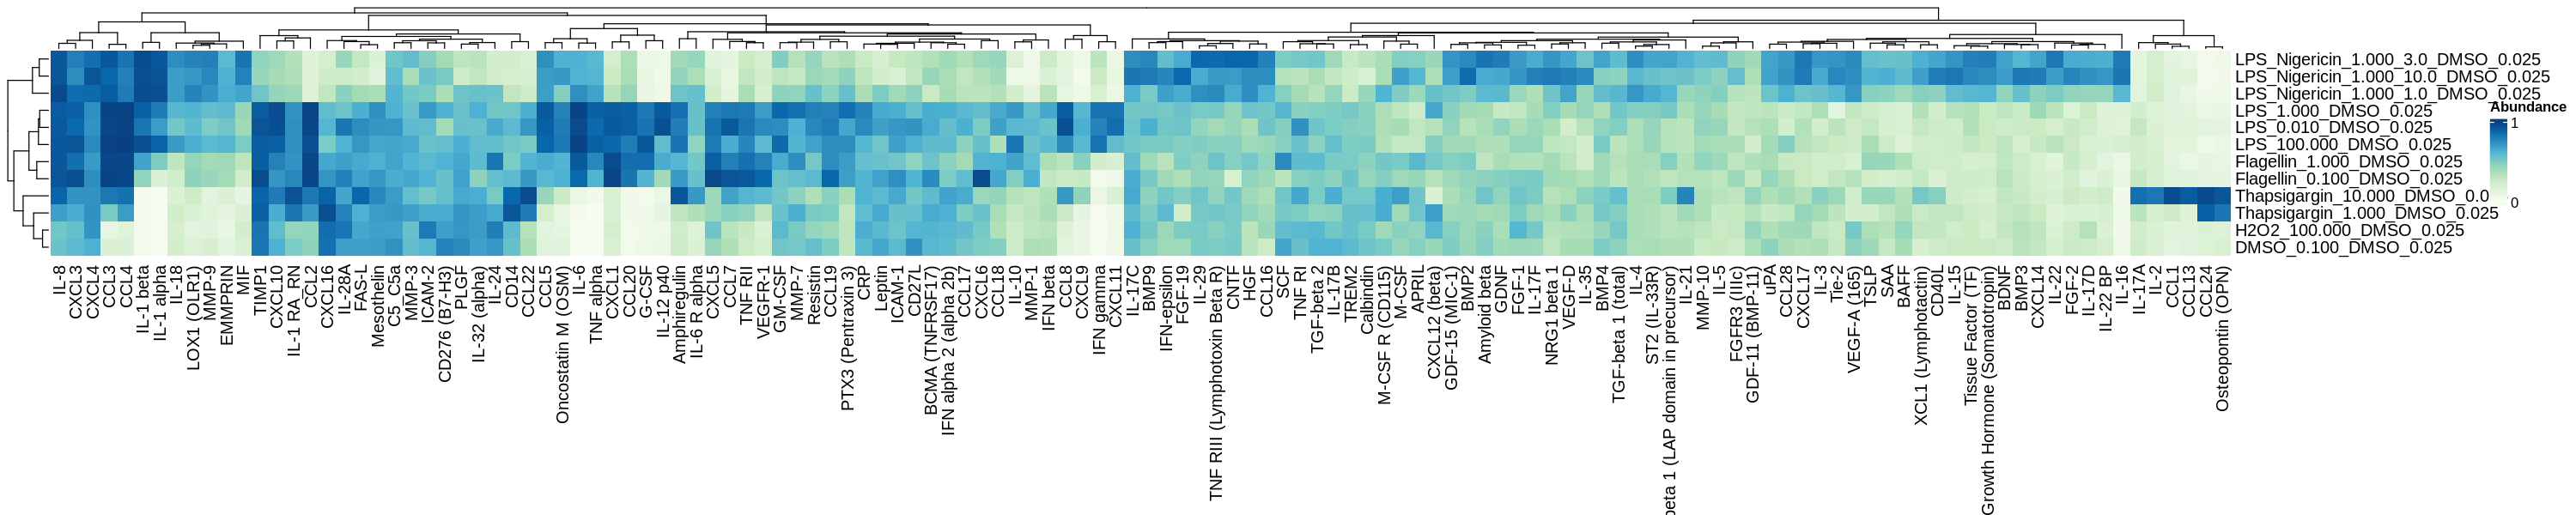

In [28]:
col_func <- colorRampPalette(brewer.pal(9, "Purples"))
# set plot size
options(repr.plot.width=25, repr.plot.height=5)
heatmap_anova_cytokines <- (
    Heatmap(
        (cytokine_values_melted_agg_filtered), 
        col = brewer.pal(9, "GnBu"),
        cluster_rows = TRUE,    # Cluster rows
        cluster_columns = TRUE, # Cluster columns
        show_row_names = TRUE,  # Show row names
        show_column_names = TRUE, # Show column names
        column_names_gp = gpar(fontsize = 12), # Column name label formatting
        row_names_gp = gpar(fontsize = 12),    # Row name label formatting
        heatmap_legend_param = list(title = "Abundance", at = c(0, 1)),
        # make the tiles rectangular
        rect_gp = gpar(col = NA)
    )
)

heatmap_anova_cytokines

## UMAP Plots

In [29]:
# read in the uamp results
umap_results_path <- file.path("..","..","2.Nomic_nELISA_Analysis/1.umap/PBMC/results/nELISA_plate_430420_umap_PBMC.csv")

umap_results_selected_treatments_path <- file.path("..","..","2.Nomic_nELISA_Analysis/1.umap/PBMC/results/nELISA_plate_430420_umap_PBMC_selected_treatments.csv")
# read in the data
umap_results <- read.csv(umap_results_path, header = TRUE, sep = ",")
umap_results_selected_treatments <- read.csv(umap_results_selected_treatments_path, header = TRUE, sep = ",")


In [30]:
umap_results_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(umap_results_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, levels = list_of_treatments)

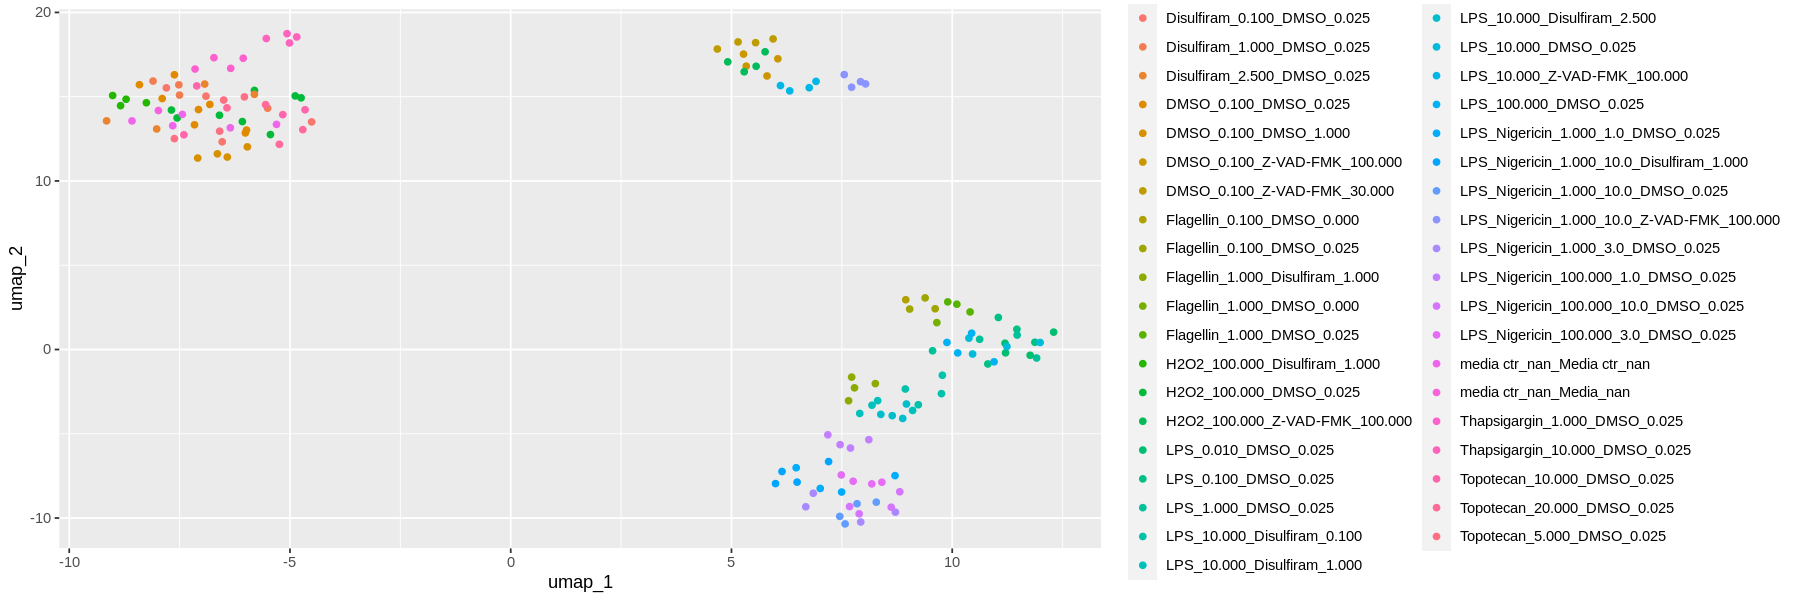

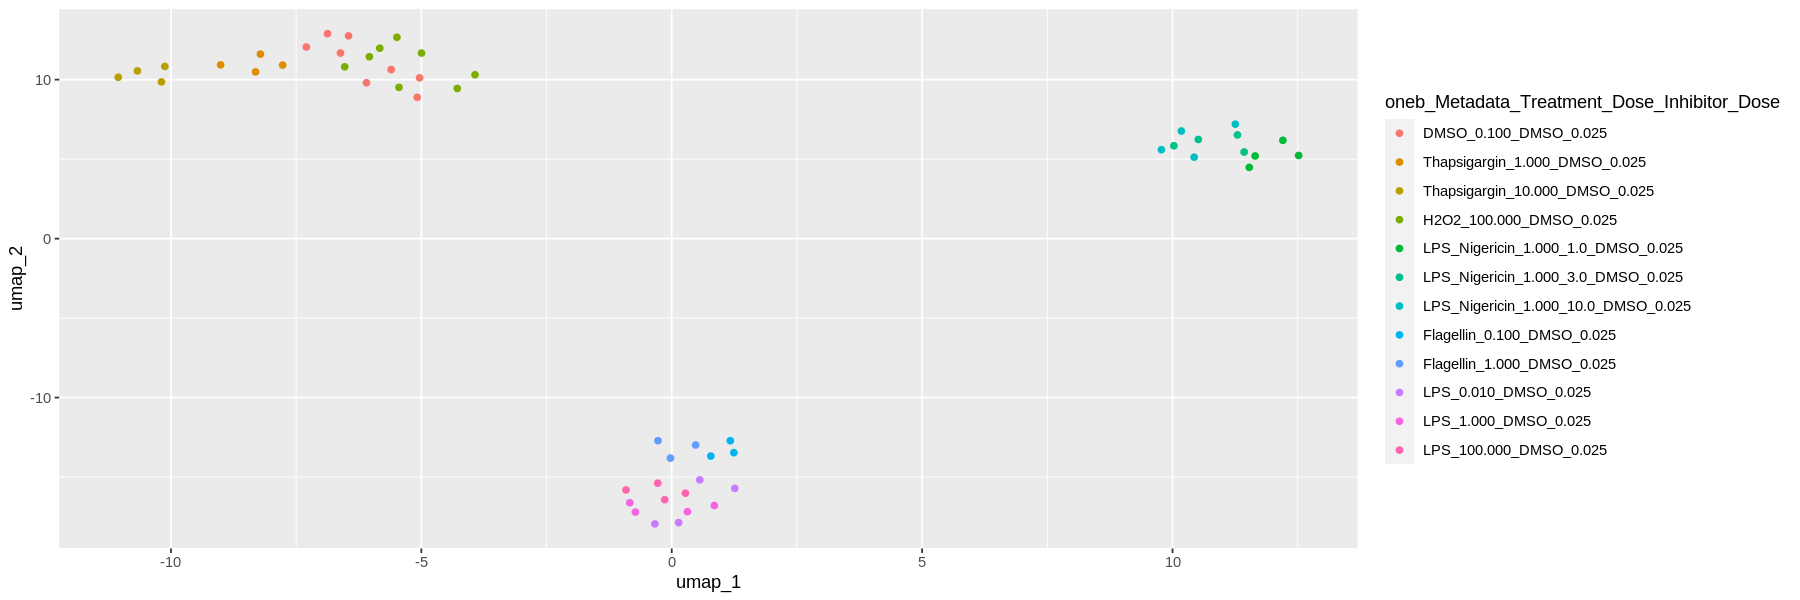

In [31]:
# set the plot size 
options(repr.plot.width=15, repr.plot.height=5)
# plot the umap results
umap_plot_all_treatments <- (
    ggplot(
        data = umap_results,
        aes(
            x = umap_1,
            y = umap_2,
            color = oneb_Metadata_Treatment_Dose_Inhibitor_Dose
        )
    )
    + geom_point()
)
umap_plot_all_treatments

# plot the umap results
umap_plot_selected_treatments <- (
    ggplot(
        data = umap_results_selected_treatments,
        aes(
            x = umap_1,
            y = umap_2,
            color = oneb_Metadata_Treatment_Dose_Inhibitor_Dose
        )
    )
    + geom_point()
)
umap_plot_selected_treatments

## Path the plots  together 

In [32]:
# show the plots first as assigned names
# set plot size 
options(repr.plot.width=5, repr.plot.height=5)

# cytokine_scatter_plot

# cytokine_bar_plot

# heatmap_plot_all
# heatmap_anova_cytokines

# umap_plot_all_treatments
# umap_plot_selected_treatments

In [33]:
new_heatmap <- as.ggplot(heatmap_anova_cytokines) 
cytokine_scatter_plot_legend <- get_legend(cytokine_scatter_plot)
umap_plot_selected_treatments_legend <- get_legend(umap_plot_selected_treatments)


# remove legends
umap_plot_selected_treatments <- umap_plot_selected_treatments + theme(legend.position = "none")
cytokine_scatter_plot <- cytokine_scatter_plot + theme(legend.position = "none")
cytokine_scatter_plot1 <- cytokine_scatter_plot1 + theme(legend.position = "none")

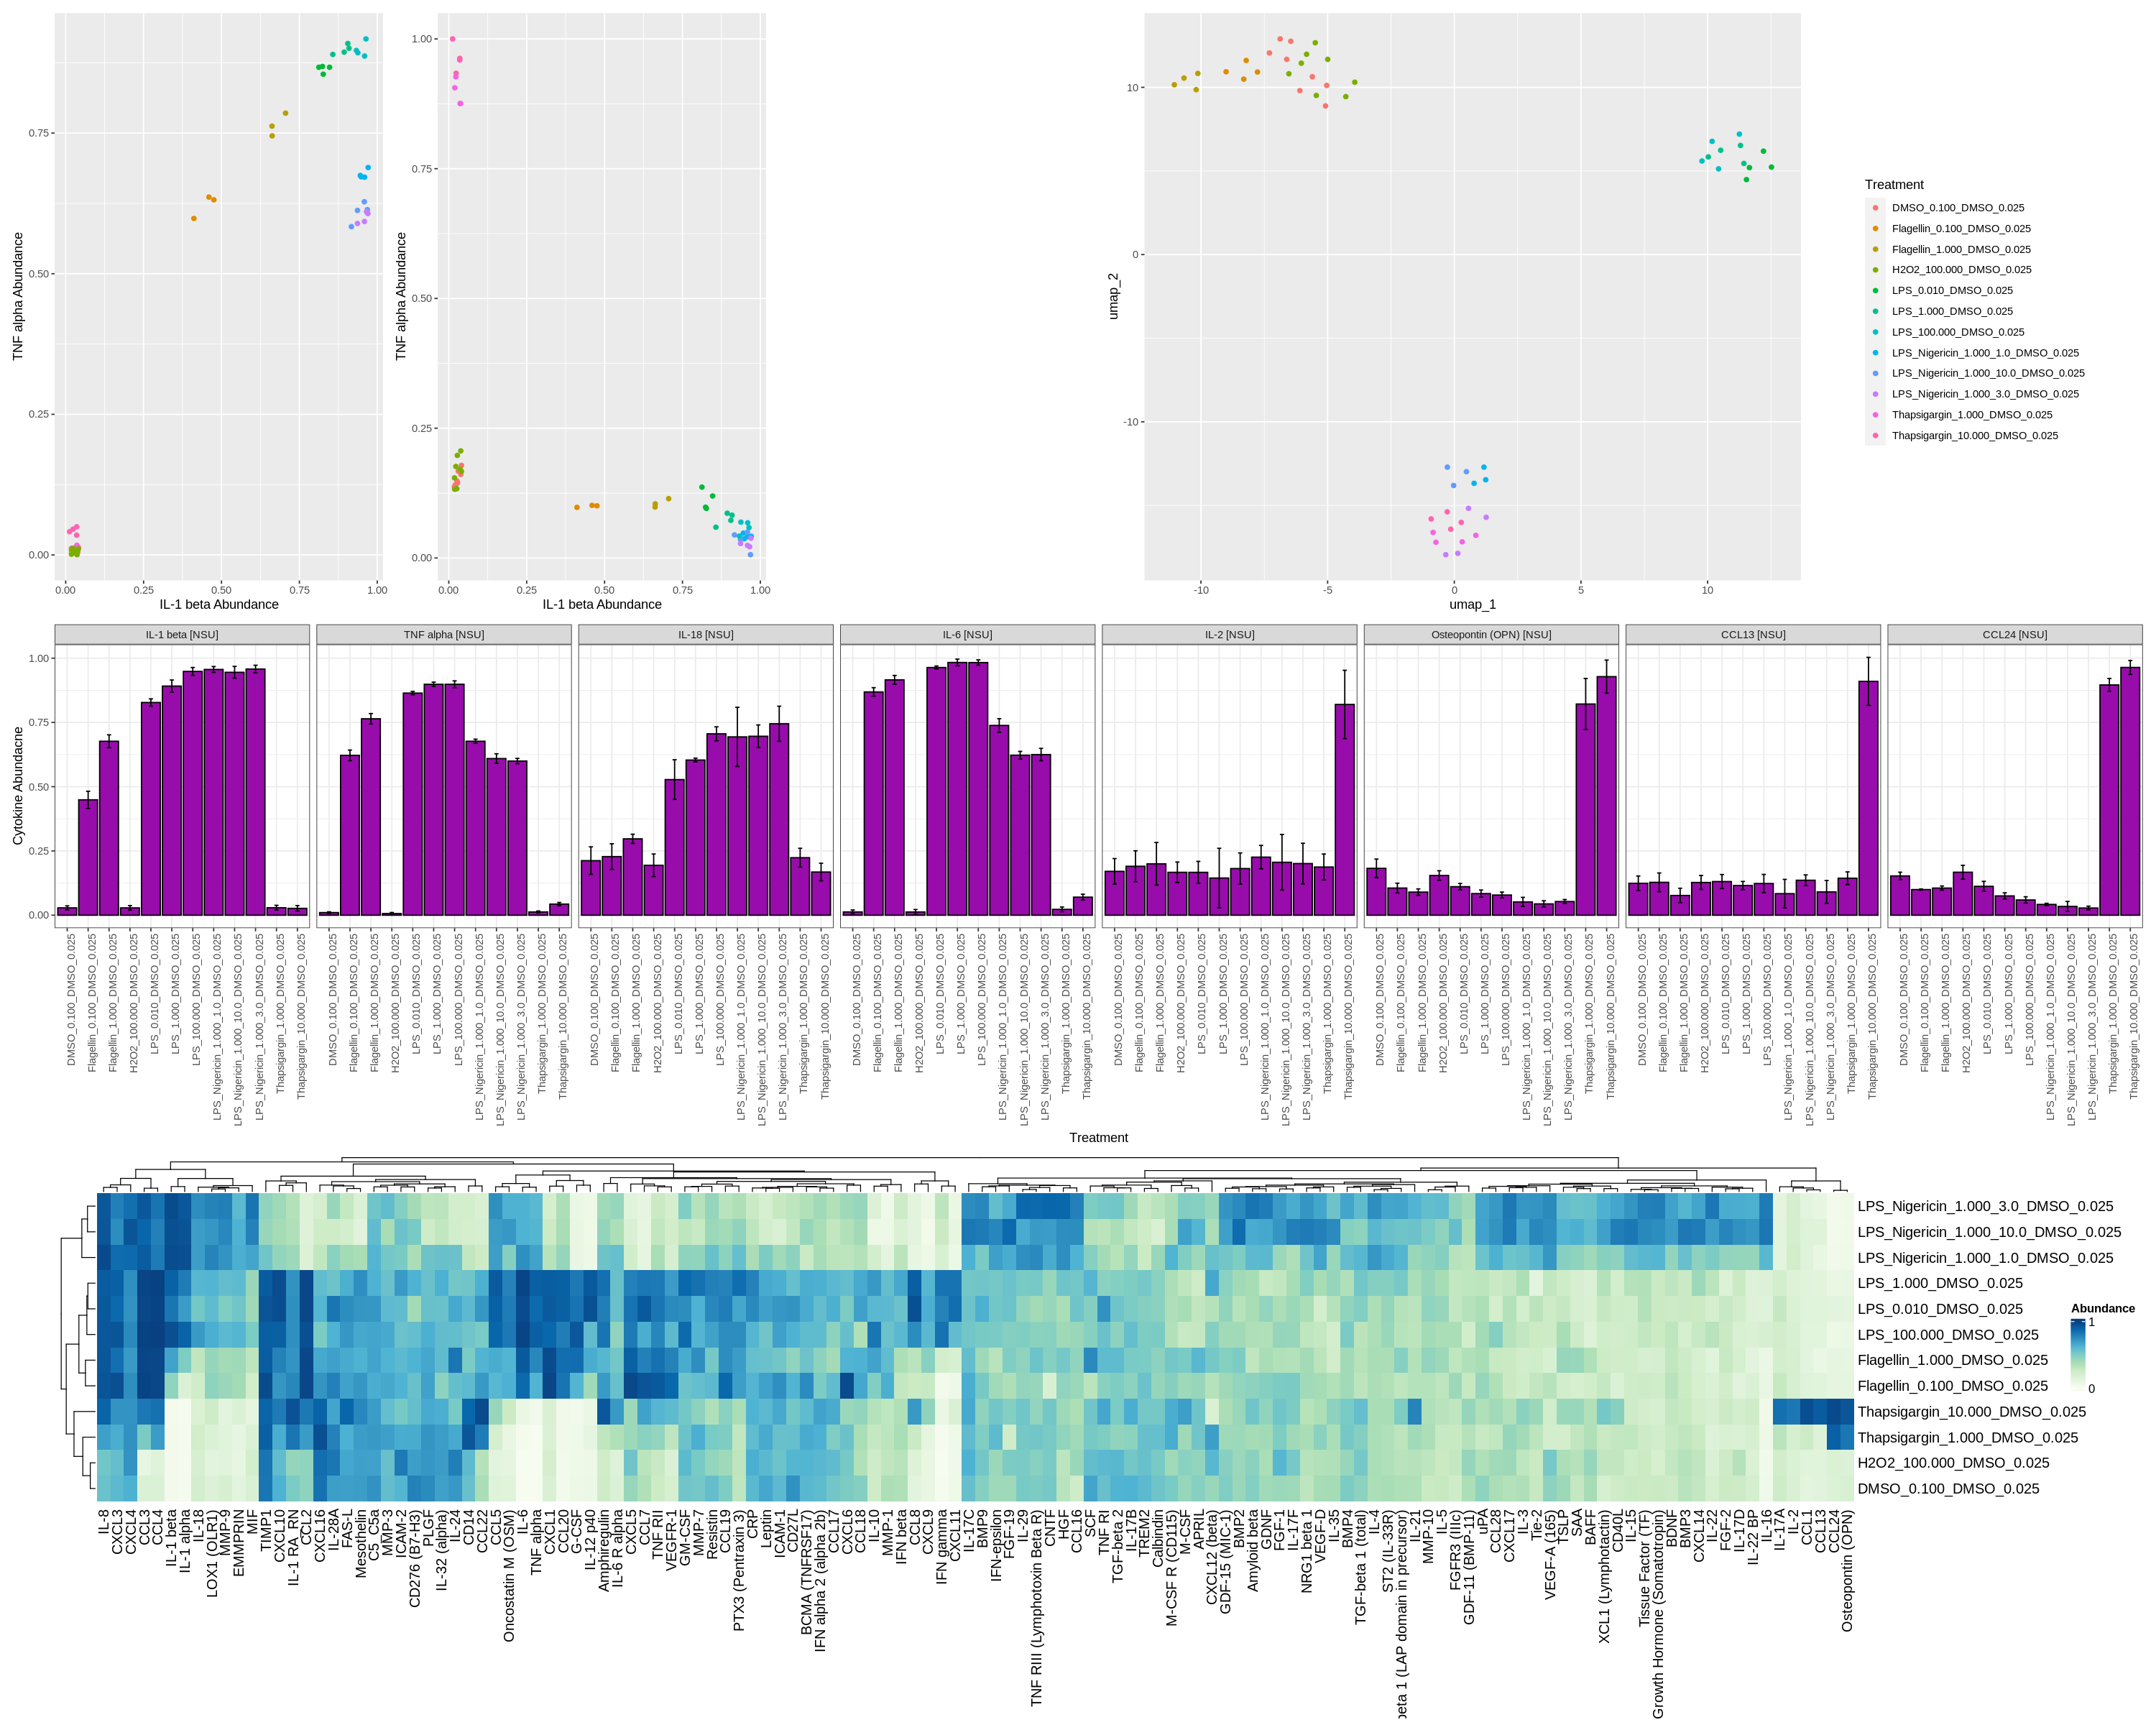

In [34]:
design <- "AB#CCD#
            AB#CCD#
            EEEEEE#
            FFFFFF#
            FFFFFF#"

# set plot size
options(repr.plot.width=25, repr.plot.height=20)
fig2 <- (
    cytokine_scatter_plot 
    + cytokine_scatter_plot1
    + umap_plot_selected_treatments
    + cytokine_scatter_plot_legend 
    + cytokine_bar_plot 
    + new_heatmap
    + plot_layout(design = design)
)
fig2
ggsave(
    filename = file.path("figure2.png"),
    plot = fig2,
    width = 25,
    height = 20,
    units = "in",
    dpi = 600
)